This code has been prouced as a teaching resource for the UKSA space software, data and AI course run by the Space South Central Universities.

Contributors to this code includes: L. Nanni; B. Canning

### Learning Outcome
<div class="alert alert-block alert-info"> 
<b>NOTE</b> In this notebook we will aim to understand how to use python to access data which is hosted online.  We will use Google Earth Engine as our case study but the approach is similar.
    <li>Authenticate yourself - might involve signing up and waiting for access</li>
    <li>Get the token and url address - often using a bespoke package</li>
    <li>Use the requests package to download the data</li>
<br>
A secondary learning outcome is to become familiar with:
    <li>The glob package to list your data</li>
    <li>The request package to send an HTTP request</li>
    <li>The rasterio package to read in raster data</li>
    <li>Expected formats for imaging data</li>
    <li>The critical importance of plotting your data</li>
</div>

# Notes on remote sensing data access

Downstream satellite data can be found from many different sources. Most of these are connected with the satellite operators. Some of the national space programs which have catalogues for data access are listed below.

1. ESA earth online data archives: https://earth.esa.int/eogateway/search?category=data or Copernicus Open Access Hub or indivdual API such as Sentinnel Hub
2. NASA Earth Science Data Systems (ESDS) : https://www.earthdata.nasa.gov/
3. JAXA Earth : https://data.earth.jaxa.jp/en/

Google, Microsoft, Amazon and other data providers also host and provide access to many data sources. A few examples to check out are:

1. Google Earth Engine: https://earthengine.google.com/
2. Microsoft planetary computer: https://planetarycomputer.microsoft.com/
3. Earth on AWS: https://aws.amazon.com/earth/

And of course the indidvual data providers such as Planet have their own APIs too.

You can also find all sorts of satellite racking information through APIs such as Space Track API, N2YO or Spectator API.

For almost everything you will need to set up your own accounts and passwords and keep authentication keys.

Here we will provide an example of how to use the Google Earth Engine API.



# Downloading remote sensing data using Google Earth Engine API

This notebook explains how to use the Google Earth Engine API to download satellite images. The Earth Engine Data Catalogue can provide both RAW and Post-Processed images from multiple satelite sources.

The steps we will take are:
1. Libraries and authentication
2. Downloading data for a given lattitude or longitude
3. Download data for a given polygon region
4. Download a collection of data, i.e. images for multiple dates in a time interval we are interested in

See information bout the Earth Engine Data Catalogue here https://developers.google.com/earth-engine/datasets

### 1) Libraries and authentication

First, we import python libraries useful to download data with the google Earth Engine API, and also libraries useful to open the data.

If you are following this code on the cluster all these packages are avalible but if you are using this code on your own systems or on a jupyter notebook server such as google colab then you will need to install some of them with the !pip comand.

geemap, gcloud, rasterio, earthengine-api and requests will all need to be installed on colab.

In [14]:
!pip --quiet install geemap gcloud rasterio earthengine-api requests pyproj

Now we import our useful standard libraries

In [15]:
import numpy as np # this is our standard 'do some efficient matrix maths' package
import matplotlib.pyplot as plt # this is our standard plotting package

We will be loading in files - perhaps many image or spatial files so we need a method of interacting with out filesystem on our computers efficiently. 'Glob' and 'os' are useful ways of doing this.

In [16]:
import glob # help us list files and recognise pathnames
import os # this package provides general functionality for our operating systems

And now some packages specific to our tasks of accessing our EO data through an API.

In [17]:
import ee # this is the earthengine-api package
import geemap.foliumap as emap # this imports a method of creating interactive maps with geemap
import requests # requests is a HTTP library and so it will enable us to send out HTTP requests to get data
import rasterio # Enable us to work efficeintly with gridded raster datasets in python
from pyproj import Geod # pyproj helps us work with coordinate transformations and projections

In the next code block, we are suppressing some of the warnings the rasterio labrary raises (we don't recommend doing this when you are writing your own code from scratch but it is helpful here to tidy up the notebook)

In [18]:
import logging
logging.getLogger('rasterio').setLevel(logging.ERROR)

For this notebook to query and download data from the Google Earth Engine API, you will need to create a credential for Google Earth Engine.

Information on how to do this is here: https://earthengine.google.com/
    * click get started (top right hand corner)
    * sign in to google and follow the direction ot register a google cloud project

In this case there is a registered project 'uksa-training-course-materials'

In [19]:
ee.Authenticate()
ee.Initialize(project="uksa-training-course-materials") # you need to copy here your credentials

Enter verification code:  4/1AanRRrtiFaC4agFKPe7JiRku6G47zNFDG17IQEUTTTpelmS__nPtD1b6KJY



Successfully saved authorization token.


Now we have successfully authenticated ourselves on google earth engine let's create somewhere for our data to live. We will do this by:

1. Creating a pathname for where we wish to store our data - **please delete the name 'beckycanning' and add you own name here**
2. Making this directory

If you are using google colab and drive then 'Mount the Drive' and define the directory for the data download - see the commented parts below.

In [60]:
### This part if you wish to play on google colab
#from google.colab import drive # needed on google colab and drive
#drive.mount('/content/drive') # needed on google colab and drive
#path='/content/drive/MyDrive/EarthEngineExampleData/'
###

# we define the path
path='/home/jovyan/data/Tutorial_data/scratch/GEE_test/beckycanning/'

# check if the directory already exists
isExist = os.path.exists(path)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(path) #we create the directory
   print("Created directory!")

Created directory!


These are all your set-up steps - we are now ready to find data with google earth engine and save it to our drive.

### 2) Downloading data for a given lattitude or longitude

To get data from an API Aplication Programming Interface) we need to know the rules for querying specific datasets and where those data are. 
The rules are generally already pre-written for you by the software package. For example Google Earth Engine has a getDownloadData (https://developers.google.com/earth-engine/apidocs/ee-data-getdownloadid) function which we will use below. The main difficulties poeple run into is 1. learning how to athenticate themselves to enable permission to Downlaod and 2. putting all the information needed to make the request for data in the correct format. Forexample ee.data.getDownloadData has a 'params' object which must be passed which specifies how to get the data. 

We need to make a query based on a region. So if we only have a lattitude and longitude point coordinate then we need to 'pad' a region around this.

In the below we define a python function that, given a location as longitude and latitude, returns a square around that area. The square size is determined by the size of the 'padding'.

In [61]:
def calculate_square_corners(pointlat, pointlong, pad=0.1):
  """
  calculate the corners of the rectangular area surrounding the given position.
  The area is defined by the padding (pad) and the location given (lat, long)

  returns:
  toplat(float), toplong (float), botlat (float), botlong (float)
  """
  toplat = pointlat + pad
  toplong = pointlong + pad
  botlat = pointlat - pad
  botlong = pointlong - pad
  return toplat, toplong, botlat, botlong


Let's now consider a point lattitude and point longitude of 30 degrees and 31 degrees and call our new function.  

In [62]:
pointlong, pointlat = 30, 31 # centre of the location we consider

# to call the function:
# 'function outputs' = function('function inputs')
toplat, toplong, botlat, botlong = calculate_square_corners(pointlat, pointlong, pad = 4) # a padding of 4 at that long and lat, is equivalent to roughly 300 km

We're now going to put those coordinates in a list and turn them into the format that google earth engine wants. This format is:

    [top lattitude, top longitude, bottom lattitude, bottom longitude]

It is very common to specifiy your polygon region in this sort of list, however, not all spatial data or EO data APIs want the order specified this way so do look it up.  

In [63]:
region_of_interest = [toplat, toplong, botlat, botlong] # we define now the area of interest
print(region_of_interest)
#this gives us a geometry object to put into our request to the API
roi =  ee.Geometry.Rectangle(region_of_interest)

[35, 34, 27, 26]


We have decided in this example to download some MODIS data products and we've decided on a time, collection and filters. 

We will use the data collection 'MODIS/061/MOD09CMG' - why, because we thought it would create a nice RGB image for this tutorial... You would need to know your reason for wanting a specific datset and then go and search for the relevent collection. It is not always straightforward to find these. 

Info on all the MODIS data products can be found here https://developers.google.com/earth-engine/datasets/catalog/modis  - open this up and see if you can find the collection we used below. It should look a little like this:

![MODIS_data_cat_snapshot.png](MODIS_data_cat_snapshot.png)

Now let's download them.

In [64]:
# Load the MODIS dataset
# selecting the instrument and the level of the data and a time period
modis = ee.ImageCollection('MODIS/061/MOD09CMG').filterDate('2023-07-01', '2023-07-31').first()
# Selecting the Red, Green, and Blue bands this time (to make a nice rgb image)
modis_rgb = modis.select(['Coarse_Resolution_Surface_Reflectance_Band_1', 'Coarse_Resolution_Surface_Reflectance_Band_4', 'Coarse_Resolution_Surface_Reflectance_Band_3'])

# Get the download URL
url = modis_rgb.getDownloadURL({
    'scale': 1000, # this is the spatial resolution we request for the data
    'region': roi,
    'format': 'GEO_TIFF'
})

Now we see how we use the 'requests' package to download data. 

This is an extremely useful package which will be your friend for accessing all sorts of data through API's including all the satelite datasets mentioned above. We will print the status code as well so you can see below. 

Status codes just tell us the status of our HTTP request - i'm sure most people are familiar with '404 - Not Found'.  200 is good - let's hope we see '200' below. 

In [65]:
response = requests.get(url) # this is the URL to use to download the data
print(response.status_code)

200


Now we save the 'content' of the response above into the path we made earlier.  

In [66]:
# this code, will download the data through the API now that our request is completed and we have the URL to use for it
file_path = path + "modis_" +str(toplat) +"-"+str(toplong) +'.tif'
with open(file_path, 'wb') as fd:
    fd.write(response.content)
    print('Download complete.')

Download complete.


We have succcessfully downloaded our data!!!

But let's now dobble check that our data are really where we expect it (under the 'path' directory we defined above) using the 'glob' package.

In [115]:
glob.glob(path+'*')

['/home/jovyan/data/Tutorial_data/scratch/GEE_test/beckycanning/modis_35-34.tif',
 '/home/jovyan/data/Tutorial_data/scratch/GEE_test/beckycanning/L8',
 '/home/jovyan/data/Tutorial_data/scratch/GEE_test/beckycanning/sentinel.tif']

The data, are now ready for us to use.
To open and read this data, we use rasterio (one of the libraries we imported)

In [67]:
# Read the GeoTIFF file using rasterio
with rasterio.open(file_path) as src:
    modis_image = src.read([1, 2, 3])  # Read the Red, Green, Blue bands

modis_image_r = np.dstack([modis_image[0], modis_image[1], modis_image[2]]) 


Now let's just plot the image using the Matplotlib package and 'imshow' which will plot multi-dimensional images for us. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


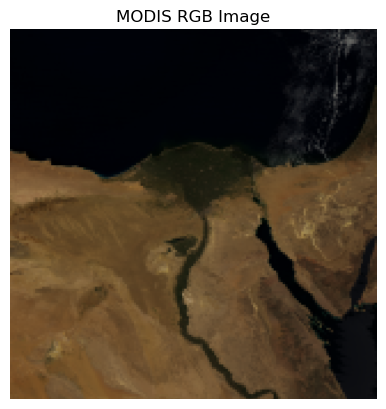

In [68]:
plt.imshow(modis_image_r)
plt.title('MODIS RGB Image')
plt.axis('off')
plt.show()

This warning is caused by the fact the data we have downloaded are not yet normalised. They are RAW data, not yet converted into RGB standard format, the format that imshow expects.

### 3) Download data for a given polygon region

This time we will define directly an area that we are interested in. Then, instead of MODIS, we will request the download of data from Sentinel
The steps are equivalent to the steps we did for MODIS! We just point to a different collection of data. We will do this in faster steps than the above but scroll up if you would like to refresh yourself on these steps.

In [75]:
### Our inputs for data location

# Initialize the Earth Engine API
ee.Initialize()

# Define a region of interest (ROI) as a polygon (e.g., in latitude and longitude)
roi = ee.Geometry.Polygon([[
    [11.331180, 44.470309],  # Coordinate of one corner
    [11.229558, 44.549367],
    [11.421254, 44.541137],
    [11.428183, 44.470309]
]])

In [76]:
### defineing the params for ee

# Define the Sentinel-2 image collection and filter by date and region
collection = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterDate('2021-09-01', '2023-09-30') \
    .filterBounds(roi) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))  # Filter images with less than 10% cloud cover

# Get the first image from the collection
image = collection.first()

# Select the desired bands (e.g., B4: Red, B3: Green, B2: Blue for RGB)
image_rgb = image.select(['B4', 'B3', 'B2'])

# Export the image to Google Drive or as a URL
url = image_rgb.getDownloadURL({
    'scale': 10,           # Set the resolution (in meters)
    'region': roi,         # Region of interest to download
    'format': 'GEO_TIFF'
})

In [116]:
### get the data and save it in our previous path

response = requests.get(url)

file_path = path + 'sentinel.tif'
with open(file_path, 'wb') as fd:
    fd.write(response.content)

glob.glob(path+'*')

['/home/jovyan/data/Tutorial_data/scratch/GEE_test/beckycanning/modis_35-34.tif',
 '/home/jovyan/data/Tutorial_data/scratch/GEE_test/beckycanning/L8',
 '/home/jovyan/data/Tutorial_data/scratch/GEE_test/beckycanning/sentinel.tif']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


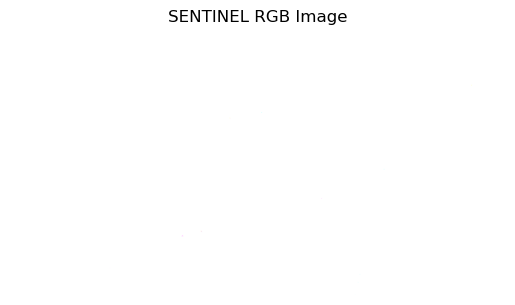

In [117]:
# Read the GeoTIFF file using rasterio
with rasterio.open(file_path) as src:
    sentinel_image = src.read([1, 2, 3])  # Read the Red, Green, Blue bands

sentinel_image_r = np.dstack([sentinel_image[0], sentinel_image[1], sentinel_image[2]])

plt.imshow(sentinel_image_r)
plt.title('SENTINEL RGB Image')
plt.axis('off')
plt.show()

Argh it did not plot!!!

Again, the data are not normalised yet, and this time imshow does not plot it as the values are beyond what it expects.  Let's look at the RAW data ranges. 

In [118]:
print(np.min(sentinel_image_r))
print(np.max(sentinel_image_r))

1
22975


We see the range is up to 22975, so we can noralise the image using the max of the range.

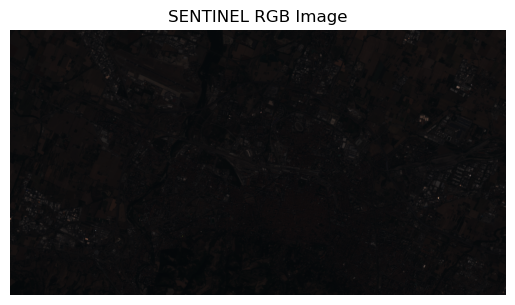

In [119]:
plt.imshow(sentinel_image_r/22975)
plt.title('SENTINEL RGB Image')
plt.axis('off')
plt.show()

Still, the image is very dark. We can normalise it, and make it brighter, using a lower value

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


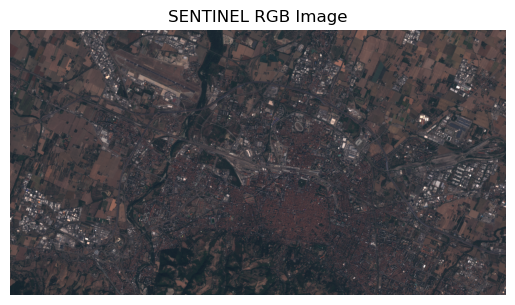

In [120]:
plt.imshow(sentinel_image_r/5000)
plt.title('SENTINEL RGB Image')
plt.axis('off')
plt.show()

<div class="alert alert-block alert-success"> 
 <strong>Exercises</strong>
 <br>
 Try various values - what happens?

Now this took some trial and error to find a nice value but let's think about how we would put this in the correct format for RGB - the warning already tells us to go to 255 as a maximum - can you code this so the values are normalise between 0-255? 

</div>

In [121]:
# write your code here



### 4) Download a collection of data, i.e. images for multiple dates in a time interval we are interested in

In this exmaple we will further complicate our code by downloading a collection of data, i.e. images for multiple dates in a time interval we are interested in. Again we will assume you are familiar with the concepts in the above examples and therefore we will move more quickly through this code. Do revise the concepts above if this is unfamilar. 

We write the following function which defines the collection of data we want to download.

In [122]:
def obtain_data(region, start_date, end_date, bands, collection_of_interest, include_end_date=False, max_cloud_cover=25):
    """
    region (geometry): region of interest
    start_date (str): Starting year for the Landsat imagery.
    end_data (str): Ending year for the Landsat imagery.
    bands(list): Bands to select from the surface reflectance product.
                                     Defaults to ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'QA_PIXEL'].
    collection_of_interest (str): Earth ENgine Catalogue Data collection of interest
    max_cloud_cover (float): max percentage of cloud coverage allowed - if the cloud coverage is higher, the img is not downloaded
    """

    start_date = ee.Date(start_date)

    if include_end_date:
        end_date = ee.Date(end_date)
    else:
        end_date = ee.Date(end_date).advance(-1, "day")

    # Filter input collections by desired date range, region and cloud coverage.
    criteria  = ee.Filter.And(
        ee.Filter.geometry(region),
        ee.Filter.date(start_date, end_date)
    )

    SAT = ee.ImageCollection(collection_of_interest) \
                      .filter(criteria) \
                      .filter(ee.Filter.lt('CLOUD_COVER', max_cloud_cover)) \
                      .select(bands)

    image_collections = {
        'SAT': SAT,
        }

    return image_collections

The following function now downloads the collection of data defined.

In [123]:
def download_data(filepath, region, scale_dict, start_date, end_date, bands, collection_of_interest, \
                  desired_collections=None, include_end_date=False, max_cloud_cover=25, overwrite=False):
    """
    filepath (str): Path to the directory where the data will be stored
    region (geometry): region of interest
    scale_dict (str): spatial resolution requested
    start_date (str): Starting year for the Landsat imagery.
    end_data (str): Ending year for the Landsat imagery.
    bands(list): Bands to select from the surface reflectance product.
                                     Defaults to ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'QA_PIXEL'].
    collection_of_interest (str): Earth Eggine Catalogue Data collection of interest
    include_end_date (bool): either False or True
    max_cloud_cover (float): max percentage of cloud coverage allowed - if the cloud coverage is higher, the img is not downloaded
    overwrite(bool): either False or True
    """

    # Obtains all image collections defined in the request function for
    # the chosen test district and date range, with maximum n% cloud cover.
    image_collections = obtain_data(
        region,
        start_date,
        end_date,
        bands,
        collection_of_interest,
        include_end_date,
        max_cloud_cover,
    )

    # Filters out unwanted collections if defined above.
    if desired_collections:
        image_collections = {
            collection: image_collections[collection] \
            for collection in desired_collections
        }

    # Creates a subfolder in the base directory for the start date
    out_dir = f'{filepath}/{start_date}'
    if not os.path.isdir(out_dir):
        os.mkdir(out_dir)

    # Iterating through each image collection.
    for collection_name, collection in image_collections.items():
        print(collection_name)
        # Counts the number of images in a collection.
        collection_size = collection.size().getInfo()

        # Skips the image collection if it contains no images.
        if collection_size == 0:
            print('No images in collection, skipping.')
            continue

        # Creates additional subfolders for each image collection.
        collection_dir = f'{out_dir}/{collection_name}'
        if not os.path.isdir(collection_dir):
            os.mkdir(collection_dir)

        # Counts number of .tif files already in image collection subfolder.
        tif_count = len(glob.glob1(collection_dir,"*.tif"))

        # Assumes the download for this collection is already complete and
        # therefore skips, provided the number of .tif files already in
        # chosen directory matches the number of images in the collection
        # and overwrite is set to False.
        if collection_size == tif_count and overwrite == False:
            print('Correct number of .tif files for image collection already in directory, skipping.')
            continue

        # Exports each image in the filtered image collection to
        # geoTIFF format.
        emap.ee_export_image_collection(
            collection,
            collection_dir,
            crs='EPSG:4326',
            scale=scale_dict[collection_name],
            region=region
        )

We define the directory where to store the data

In [124]:
#filepath = os.mkdir("/content/drive/MyDrive/EarthEngineExampleData/L8") # example of a google drive folder

### PLEASE EDIT THE FILE PATH TO YOUR OWN NAME

filepath = '/home/jovyan/data/Tutorial_data/scratch/GEE_test/beckycanning/L8/'
# check if the directory already exists
isExist = os.path.exists(filepath)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(filepath) #we create the directory
   print("Created directory!")

We define will now define our latitude and longitude and use our first function from exercise 2. to calculate the region of interest as a padded square around this lat and long.

In [107]:
pointlong, pointlat = 50.810993, -1.094974
toplat, toplong, botlat, botlong = calculate_square_corners(pointlat, pointlong, pad=0.13456632) # we use the function defined earlier
region_of_interest = [toplat, toplong, botlat, botlong]
region =  ee.Geometry.Rectangle(region_of_interest)

We will also define a time interval of interest.

In [108]:
years = ["2023", "2024"]
months = ["06", "07", "08"] #let's consider only the summer months

date_list = [f"{year}-{month}-01" for year in years for month in months]
date_list.append("2024-01-01")

dates = [(date_list[i], date_list[i+1]) for i in range(len(date_list)-1)][0:-1]

dates

[('2023-06-01', '2023-07-01'),
 ('2023-07-01', '2023-08-01'),
 ('2023-08-01', '2024-06-01'),
 ('2024-06-01', '2024-07-01'),
 ('2024-07-01', '2024-08-01')]

Finally we will define the spatial resolution for the data we wish to download.

In [109]:
# Defines the desired pixel scale for each image, have set to the native resolution of each satellite.
scale_dict = {
    'SAT': 30
}

Now let's use our functions above to download our data. 

We will call our function

        download_data()

and it calls our function 

        obtain_data()



In [110]:
for start_date, end_date in dates:
    print(start_date, end_date)
    download_data(
        filepath=filepath,
        region=region,
        scale_dict=scale_dict,
        start_date=start_date,
        end_date=end_date,
        include_end_date=False,
        max_cloud_cover=25,
        bands=['B2', 'B3', 'B4', 'B5', 'B6', 'B7'],
        collection_of_interest="LANDSAT/LC08/C02/T1",
        desired_collections=None,
        overwrite=True
    )

2023-06-01 2023-07-01
SAT
No images in collection, skipping.
2023-07-01 2023-08-01
SAT
No images in collection, skipping.
2023-08-01 2024-06-01
SAT
Total number of images: 9

Exporting 1/9: /home/jovyan/data/Tutorial_data/scratch/GEE_test/beckycanning/L8//2023-08-01/SAT/LC08_201025_20230915.tif
Generating URL ...
Please wait ...
Data downloaded to /home/jovyan/data/Tutorial_data/scratch/GEE_test/beckycanning/L8/2023-08-01/SAT/LC08_201025_20230915.tif


Exporting 2/9: /home/jovyan/data/Tutorial_data/scratch/GEE_test/beckycanning/L8//2023-08-01/SAT/LC08_201025_20231017.tif
Generating URL ...
Please wait ...
Data downloaded to /home/jovyan/data/Tutorial_data/scratch/GEE_test/beckycanning/L8/2023-08-01/SAT/LC08_201025_20231017.tif


Exporting 3/9: /home/jovyan/data/Tutorial_data/scratch/GEE_test/beckycanning/L8//2023-08-01/SAT/LC08_201025_20240512.tif
Generating URL ...
Please wait ...
Data downloaded to /home/jovyan/data/Tutorial_data/scratch/GEE_test/beckycanning/L8/2023-08-01/SAT/LC08_2

<div class="alert alert-block alert-success"> 
 <strong>Exercises</strong>
 <br>
 <li>Try to read in one of these images and plot it</li>
 <li>Try to read in many of these images</li>
 <li>Try to normalise and plot several images toegther think about changes you can see in these images of the same location</li>
 <li>Are these images always on the same scales? Do any have midding numbers or other issues in the images?</li>
 <li>Are all these folders we made full - if not why not? How could we make this code more efficient so we are not leaving empty folders about the place?</li>
</div>

In [129]:
glob.glob(filepath+'*/*/*')

['/home/jovyan/data/Tutorial_data/scratch/GEE_test/beckycanning/L8/2024-06-01/SAT/LC08_202025_20240620.tif',
 '/home/jovyan/data/Tutorial_data/scratch/GEE_test/beckycanning/L8/2023-08-01/SAT/LC08_201025_20230915.tif',
 '/home/jovyan/data/Tutorial_data/scratch/GEE_test/beckycanning/L8/2023-08-01/SAT/LC08_202025_20231211.tif',
 '/home/jovyan/data/Tutorial_data/scratch/GEE_test/beckycanning/L8/2023-08-01/SAT/LC08_202025_20231125.tif',
 '/home/jovyan/data/Tutorial_data/scratch/GEE_test/beckycanning/L8/2023-08-01/SAT/LC08_201025_20231017.tif',
 '/home/jovyan/data/Tutorial_data/scratch/GEE_test/beckycanning/L8/2023-08-01/SAT/LC08_201025_20240512.tif',
 '/home/jovyan/data/Tutorial_data/scratch/GEE_test/beckycanning/L8/2023-08-01/SAT/LC08_202024_20230906.tif',
 '/home/jovyan/data/Tutorial_data/scratch/GEE_test/beckycanning/L8/2023-08-01/SAT/LC08_202024_20240519.tif',
 '/home/jovyan/data/Tutorial_data/scratch/GEE_test/beckycanning/L8/2023-08-01/SAT/LC08_202025_20240519.tif',
 '/home/jovyan/data